# Cluster evaluation

This notebook evaluates the quality of the zone–hour demand clusters.
We assess different numbers of clusters using quantitative metrics and use the results to select an appropriate K for interpretation.

In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

DATA_PATH = "../../data/processed/zone_hour_clusters.parquet"

In [2]:
df = pd.read_parquet(DATA_PATH)
df.head()

,zone_id,pickup_hour_ts,demand,avg_fare,avg_distance,hour,day_of_week,is_weekend,day,month,cluster
0,1,2019-01-01 10:00:00,2,61.25,16.90,10,1,0,1,1,3
1,1,2019-01-01 12:00:00,1,135.00,19.30,12,1,0,1,1,3
2,1,2019-01-01 15:00:00,1,106.00,41.28,15,1,0,1,1,3
3,1,2019-01-02 02:00:00,1,30.00,1.27,2,2,0,2,1,0
4,1,2019-01-02 03:00:00,1,15.00,12.65,3,2,0,2,1,0


In [3]:
NORMALIZED_FEATURES_PATH = "../../data/processed/clustering_features_scaled.parquet"
df_norm = pd.read_parquet(NORMALIZED_FEATURES_PATH)
df_norm

,demand,avg_fare,avg_distance,hour,day_of_week,is_weekend
0,-0.510605,2.804334,2.573686,-0.268839,-1.032703,-0.631532
1,-0.517717,7.691289,3.091599,0.036880,-1.032703,-0.631532
2,-0.517717,5.769639,7.834817,0.495459,-1.032703,-0.631532
3,-0.517717,0.733590,-0.799221,-1.491717,-0.526064,-0.631532
4,-0.517717,-0.260367,1.656549,-1.338857,-0.526064,-0.631532
...,...,...,...,...,...,...
296802,-0.496382,2.829183,0.008939,1.106898,1.500496,1.583452
296803,-0.489270,5.153385,5.561612,1.259758,1.500496,1.583452
296804,-0.517717,1.182859,2.096775,1.412618,1.500496,1.583452
296805,-0.510605,0.020260,0.324003,1.565477,1.500496,1.583452


In [4]:
X = df_norm.values
X

array([[-0.51060548,  2.80433372,  2.57368633, -0.2688393 , -1.03270344,
        -0.63153158],
       [-0.51771742,  7.69128887,  3.09159913,  0.03688014, -1.03270344,
        -0.63153158],
       [-0.51771742,  5.76963871,  7.83481719,  0.49545931, -1.03270344,
        -0.63153158],
       ...,
       [-0.51771742,  1.18285857,  2.09677496,  1.41261765,  1.5004962 ,
         1.58345209],
       [-0.51060548,  0.02026022,  0.3240026 ,  1.56547738,  1.5004962 ,
         1.58345209],
       [-0.51771742, -0.62481786, -0.60068754,  1.7183371 ,  1.5004962 ,
         1.58345209]], shape=(296807, 6))

### Define range of K to be tested
We evaluate clustering quality for a range of cluster counts.

In [20]:
K_range = range(2, 11)

### Compute evaluation metrics for each K

In [21]:
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []

In [22]:
for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    
    labels = kmeans.fit_predict(X)
    
    inertias.append(kmeans.inertia_)

    score = silhouette_score(
        X,
        labels,
        sample_size=5000,
        random_state=42
    )
    silhouettes.append(score)

### Plot elbow curve
The elbow plot shows how within-cluster variance changes with K.

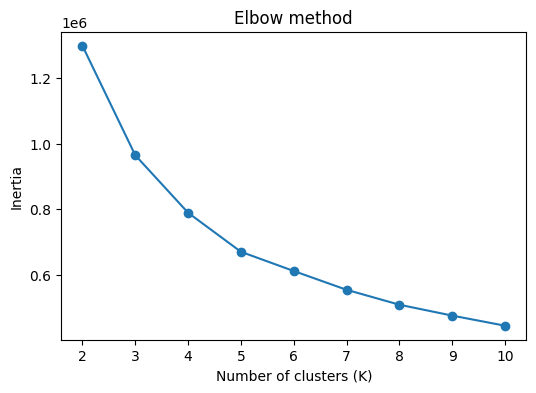

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.show()

### Plot silhouette scores
Silhouette scores measure how well-separated the clusters are.

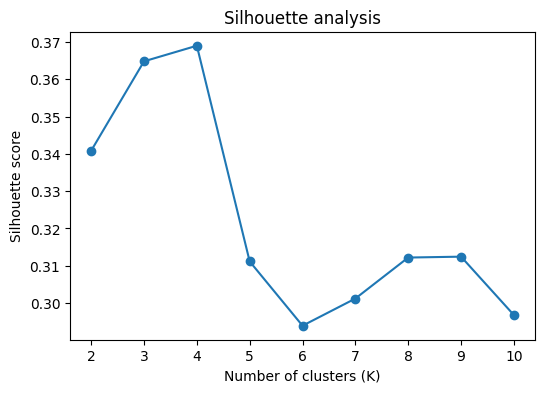

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(list(K_range), silhouettes, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette analysis")
plt.show()

In [25]:
pd.DataFrame({
    "K": list(K_range),
    "inertia": inertias,
    "silhouette": silhouettes
})

,K,inertia,silhouette
0,2,1.298793e+06,0.340828
1,3,9.647810e+05,0.364800
2,4,7.893067e+05,0.368985
3,5,6.701857e+05,0.311140
4,6,6.115452e+05,0.293908
5,7,5.542503e+05,0.301192
6,8,5.087097e+05,0.312188
7,9,4.754762e+05,0.312425
8,10,4.446964e+05,0.296771


## Interpretation

The silhouette score increases from K = 2 to K = 4 and reaches its maximum at K = 4 (0.369). For K > 4 the silhouette score decreases, indicating that additional clusters do not improve the separation between demand patterns.

The inertia curve shows a clear reduction up to K = 4, after which the improvements become more gradual.

Considering both cluster compactness and separation, K = 4 is selected as a suitable trade-off between model quality and interpretability.